# Getting started

We introduce the basics of GRANAD and do a quick simulation.

## Introduction

GRANAD lets you simulate structures from a few orbitals up to finite bulks. The process of specifying a structure is designed to be easy and interactive: You can add, shift, combine and manipulate parts of your structure at varying levels of detail involving large groups of orbitals or just single orbitals. To this end, GRANAD offers three fundamental datatypes:

1. *Orbitals* are the fundamental building block of a structure.
2. *OrbitalLists* represent a concrete structure. In essence, you can handle these as normal Python lists with additional information regarding Orbital coupling.
3. *Materials* are a stand-in for infinite bulks. You can cut finite pieces from these bulks, which are again just lists of orbitals.

We will use each of them below to set up a small graphene nanoantenna coupling to an external field.

Once this is done, we will use GRANAD's main feature and simulate the induced dynamics in the nanoantenna directly in time domain.

## Orbitals

At its core, GRANAD is all about orbitals. Here we create an orbital and print its properties to understand its structure.


In [1]:
from granad import Orbital

my_first_orbital = Orbital(
    tag = "a tag contains arbitrary information",
)
print(my_first_orbital)

{'position': Array([0., 0., 0.], dtype=float64),
 'layer_index': None,
 'tag': 'a tag contains arbitrary information',
 'energy_level': None,
 'angular_momentum': None,
 'angular_momentum_z': None,
 'spin': None,
 'atom_name': None,
 'group_id': GroupId(id=1)}


The group_id, unsurprisingly, groups orbitals. It shouldn't concern us too much now. From the output above, we see that orbitals are placed at the origin by default. We can change this by passing an explicit position.

In [2]:

my_second_orbital = Orbital(
    position = (1, 1, 1),
    tag = "a new, shifted orbital",
)
print(my_second_orbital)


{'position': Array([1., 1., 1.], dtype=float64),
 'layer_index': None,
 'tag': 'a new, shifted orbital',
 'energy_level': None,
 'angular_momentum': None,
 'angular_momentum_z': None,
 'spin': None,
 'atom_name': None,
 'group_id': GroupId(id=2)}


This is all there is to know about orbitals!


## Materials

Materials are stuff you can cut orbitals from. You can define one yourself or import a prebuilt one. We will use the latter option.

In [3]:
from granad import MaterialCatalog
MaterialCatalog.available()

Available materials:
graphene
ssh
metal_1d
MoS2
hBN


Let's inspect a material.

In [4]:
MaterialCatalog.describe("graphene")

<function get_graphene at 0x7fcd6e08efc0>


There are parameters regarding the geometry, the type of the involved orbitals (the built-in graphene model contains only a single pz orbital per atom), the position of orbitals in the unit cell and the interactions (currently, GRANAD supports hoppings and Coulomb interactions). Let's pick a concrete material.

In [5]:
graphene = MaterialCatalog.get("graphene")

## OrbitalLists

OrbitalLists are the last class you need to know. Unsurprisingly, an OrbitalList is a list of orbitals. You can create one yourself from the two orbitals you created above

In [6]:
from granad import OrbitalList

my_first_orbital_list = OrbitalList([my_first_orbital, my_second_orbital])
print(my_first_orbital_list)

List with 2 orbitals, 2 electrons.Excitation: f[Array([0], dtype=int64), Array([0], dtype=int64), Array([0], dtype=int64)]
[Orbital(position=Array([0., 0., 0.], dtype=float64), layer_index=None, tag='a tag contains arbitrary information', energy_level=None, angular_momentum=None, angular_momentum_z=None, spin=None, atom_name=None, group_id=GroupId(id=1)), Orbital(position=Array([1., 1., 1.], dtype=float64), layer_index=None, tag='a new, shifted orbital', energy_level=None, angular_momentum=None, angular_momentum_z=None, spin=None, atom_name=None, group_id=GroupId(id=2))]


Alternatively, you get orbital lists if you cut a flake from a material. You do this by specifying the shape of the flake.
You can specify any shape you want, but this is covered in a separate tutorial.
For now, we will use a built-in shape: an hexagon with a base length of 10 Angström.

In [7]:
from granad import Triangle
import jax.numpy as jnp
triangle = Triangle(18)

Now, our shape is ready and we can start cutting. To make sure that we are satisfied with what we get, we plot the flake. By default, GRANAD cuts any "dangling" atoms.

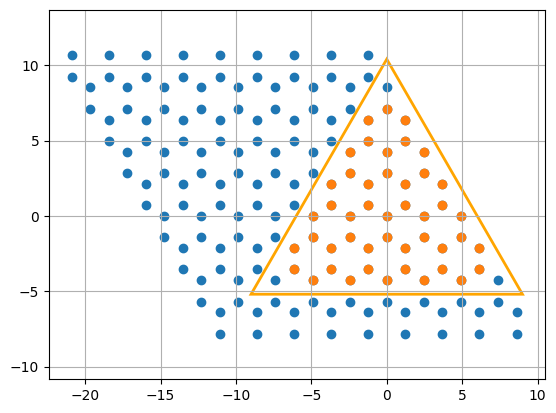

List with 46 orbitals, 46 electrons.Excitation: f[Array([0], dtype=int64), Array([0], dtype=int64), Array([0], dtype=int64)]
[Orbital(position=Array([-4.92      , -4.26084499,  0.        ], dtype=float64), layer_index=0, tag='sublattice_1', energy_level=0, angular_momentum=1, angular_momentum_z=0, spin=0, atom_name='C', group_id=GroupId(id=3)), Orbital(position=Array([-6.15      , -2.13042249,  0.        ], dtype=float64), layer_index=1, tag='sublattice_1', energy_level=0, angular_momentum=1, angular_momentum_z=0, spin=0, atom_name='C', group_id=GroupId(id=3)), Orbital(position=Array([-2.46      , -4.26084499,  0.        ], dtype=float64), layer_index=2, tag='sublattice_1', energy_level=0, angular_momentum=1, angular_momentum_z=0, spin=0, atom_name='C', group_id=GroupId(id=3)), Orbital(position=Array([-3.69      , -2.13042249,  0.        ], dtype=float64), layer_index=3, tag='sublattice_1', energy_level=0, angular_momentum=1, angular_momentum_z=0, spin=0, atom_name='C', group_id=GroupI

In [8]:
my_first_flake = graphene.cut_flake(triangle, plot = True)
print(my_first_flake)

There is an extra option for dealing with graphene-like lattices we can pass to the built-in shape, which is the armchair boolean. It just rotates the shape to get the correct edge type. The optional "shift" argument lets you shift the shape in the plane.

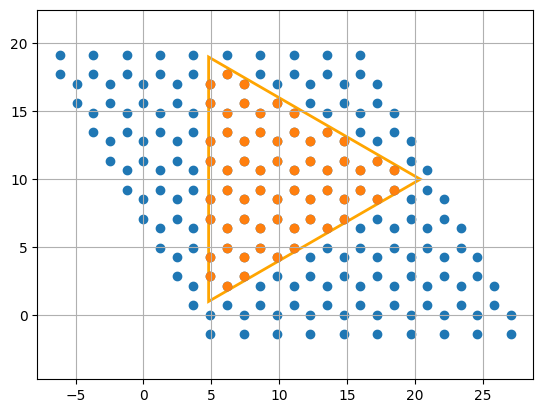

In [9]:
triangle_ac = Triangle(18, armchair = True)
my_first_flake = graphene.cut_flake(triangle_ac, plot = True)

For more information on cutting, including different edge types and how to keep dangling atoms, have a look at the corresponding tutorial.

## A first simulation

Physical observables are expectation values of Hermitian operators. GRANAD offers access to the time-resolved density matrix $\rho(t)$ of a system by integrating a nonlinear master equation. Once the time dependent density matrix is known, dynamical expectation values can be computed. Say you have a Hermitian operator epresented by a matrix $A$ and the solution of the master equation $\rho(t)$. The expectation value is then just $a(t) = \text{Tr}[\rho(t) A]$. We will illustrate this at the example of the dipole moment in the small graphene flake we created above.

But before we dive into exploring the dynamics of the flake, we first inspect its energies

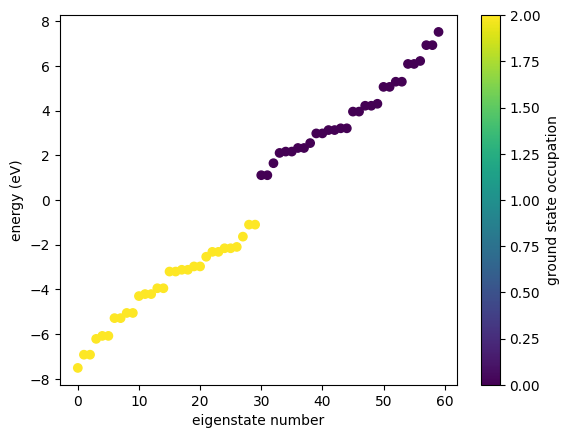

In [10]:
my_first_flake.show_energies()

GRANAD offers similar built-in functions to visualize (both static and dynamic) properties of a flake. For more information, please consult the corresponding tutorial.

Now that we are ready, we can study the induced dipole moment. In particular, we will:

1. Excite the flake with an electric field.
2. Compute its dipole moment $p(t) = \text{Tr}[\rho(t) P]$

The electric field is given as a function mapping the time (a single float) to a vector representing the field components like this `field : t -> vec`.

You can specify custom functions, but GRANAD comes with a few built-ins. We will just use the built-in Pulse.

In [11]:
from granad import Pulse

my_first_illumination = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)
print( my_first_illumination( 0.0) ) # initial value of the field

[2.60905079e-13-1.44036042e-13j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j]


Now we come to the actual simulation. For any time-domain simulation, we have to decide on a few additional parameters:

1. Simulation duration: we go from 0 to 40 to make sure everything has equilibrated.
2. Relaxation rate: here, we pick a single number characterizing the rate of energy dissipation across all channels.
3. The operators whose expectation values we want to compute. They are given as a simple list.

We want to calculate the induced polarization from the dipole operator. This operator can be represented as a 3xNxN matrix, where N is the number of orbitals and 3 corresponds to Cartesian components x,y,z and we can compute it directly

In [12]:
print(my_first_flake.dipole_operator.shape)

(3, 60, 60)


We want to compute its expectation value, so we have to wrap it in a list and pass it to the TD simulation, called `master_equation`

In [13]:
result = my_first_flake.master_equation(
    end_time=40, # the start is set to 0 by default 
    relaxation_rate=1 / 10,
    illumination=my_first_illumination,
    expectation_values = [my_first_flake.dipole_operator] # you can also omit the list for a single operator, but this is bad practice
    )

RHS compiled
RHS compiled


100.0 %


If you want to compute expecation values of more operators, you can simply add them to the list. The result variable is a container for 

1. the last density matrix in the simulation (this is important if you want to continue the time evolution).
2. the time axis, which is an array of samples [t_1, t_2, ... t_n].
3. an "output", which is a list of arrays, corresponding to the operators we passed in. Each array contains the time-dependent expectation value like [p_1, p_2, ..., p_n].

We have only specified one operator to compute the expectation value of, such the list only contains one element.

In [14]:
print(len(result.output))

1


This list contains an array of shape Tx3. So, if we want the dipole moment at the 10-th timestep in x-direction, we would do

In [15]:
dipole_moments = result.output[0]
print(dipole_moments[10, 0])

(3.4130823167721756e-13+0j)


Now that we understand how a time domain simulation works, we can visualize the result. GRANAD offers a dedicated function for this

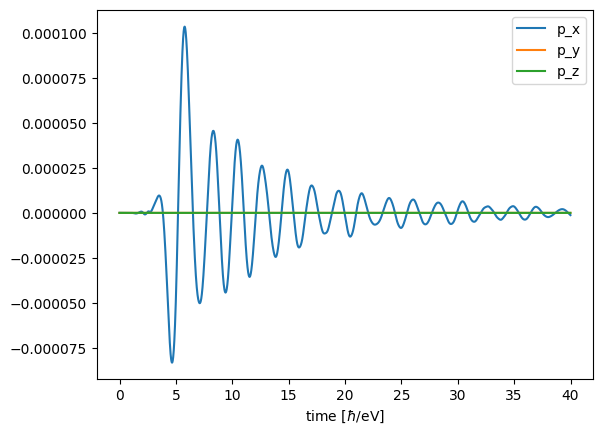

In [16]:
my_first_flake.show_res( result, plot_labels = ["p_x", "p_y", "p_z"], show_illumination = False ) 